In [121]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import networkx as nx

from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score, roc_curve, auc, brier_score_loss
from sklearn.exceptions import ConvergenceWarning
from sklearn import set_config

from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.utils import concordance_index
from lifelines.statistics import logrank_test, multivariate_logrank_test

from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

%matplotlib inline

# Configuring warnings and sklearn display
warnings.filterwarnings('ignore')
set_config(display="text")

## Set Filename and Directory

In [122]:
dir = '../'
latent_path = 'output/latent'
model_path = 'vae'
model_name = 'vae'
file_path = os.path.join(dir, latent_path, model_path)

## Rescaling Data

In [123]:
def median_scaling(df, feature_columns):
    # Isolate feature columns for scaling
    features_df = df[feature_columns]

    # Calculate the median and MAD for each feature
    medians = features_df.median()
    mads = features_df.mad()

    # Scale each feature
    scaled_features = features_df.apply(lambda x: (x - medians.loc[x.name]) / mads.loc[x.name], axis=0)
    
    # Merge the scaled features back with the non-scaled columns
    non_feature_columns = df.drop(columns=feature_columns)
    scaled_df = pd.concat([non_feature_columns, scaled_features], axis=1)

    return scaled_df

## Feature Selection - Cox-PH

In [124]:
def select_significant_features(data, features, num_features_to_select=15):
    feature_p_values = []

    for feature in features:
        cph = CoxPHFitter()
        df = data[[feature, 'months', 'status']]
        cph.fit(df, duration_col='months', event_col='status')
        p_value = cph.summary.loc[feature, 'p']
        feature_p_values.append((feature, p_value))

    # Sort features by their p-values and select the top 15
    sorted_features = sorted(feature_p_values, key=lambda x: x[1])
    selected_features = [feature for feature, p in sorted_features[:num_features_to_select]]

    # get the summary
    selected_data = data[selected_features + ['months', 'status']]
    final_cph = CoxPHFitter()
    final_cph.fit(selected_data, duration_col='months', event_col='status')
    summary = final_cph.summary

    return selected_features, summary

## K-means Clustering

In [125]:
def determine_optimal_clusters(data, max_k=10):
    silhouette_scores = []
    ch_scores = []
    for k in range(2, max_k + 1):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(data)
        silhouette_scores.append(silhouette_score(data, labels))
        ch_scores.append(calinski_harabasz_score(data, labels))

    best_k_silhouette = np.argmax(silhouette_scores) + 2
    best_k_ch = np.argmax(ch_scores) + 2
    return best_k_silhouette, best_k_ch

## Build SVM Classifier

In [126]:
def train_svm_with_gridsearch(X_train, y_train):
    param_grid = {'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['rbf', 'linear']}
    
    grid = GridSearchCV(SVC(), param_grid, refit=True, cv=5)
    grid.fit(X_train, y_train)
    return grid.best_estimator_

## Build Random Forest Classifier

In [127]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

def train_random_forest_with_gridsearch(X_train, y_train):
    # Define the parameter grid: 
    # n_estimators is the number of trees in the forest
    # max_features is the number of features to consider for the best split
    # max_depth is the maximum depth of the tree
    # min_samples_split is the minimum number of samples required to split an internal node
    # min_samples_leaf is the minimum number of samples required to be at a leaf node
    param_grid = {
        'n_estimators': [100, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth': [4, 6],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize the GridSearchCV object with RandomForestClassifier and the parameter grid
    grid = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, cv=5, verbose=0)

    # Fit the model on the training data
    grid.fit(X_train, y_train)

    # Return the best model found
    return grid.best_estimator_

## Evaluate Model

In [128]:
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    if sum(predictions) == 0:
        return 0
    c_index = concordance_index(y_test['status'], y_test['months'], predictions)
    return c_index

In [129]:
n_splits = 10
c_index_list = []
max_c_index = float("-inf")
best_fold = None
best_summary = None

for i in range(1, n_splits+1):
    train_data = pd.read_csv(os.path.join(file_path, f'{model_name}_merged_train_{i}.csv'))
    test_data = pd.read_csv(os.path.join(file_path, f'{model_name}_merged_validation_{i}.csv'))
    train_data['status'] = train_data['status'].replace({'Alive': 0, 'Dead': 1})
    train_data = train_data.dropna()
    test_data['status'] = test_data['status'].replace({'Alive': 0, 'Dead': 1})
    test_data = test_data.dropna()
    
    feature_columns = train_data.drop(columns=['Unnamed: 0','status', 'months']).columns
    
    scaled_train_data = median_scaling(train_data, feature_columns)
    scaled_test_data = median_scaling(test_data, feature_columns)

    # Step 1: Feature selection using Cox-PH models
    significant_features, summary = select_significant_features(scaled_train_data, feature_columns)

    # Step 2: K-means Clustering
    optimal_k_silhouette, optimal_k_ch = determine_optimal_clusters(scaled_train_data[significant_features])
    kmeans = KMeans(n_clusters=optimal_k_silhouette, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_train_data[significant_features])

    # Step 3: SVM Classifier
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(scaled_train_data[significant_features])
    svm_model = train_svm_with_gridsearch(X_train_scaled, cluster_labels)

    # Step 4: Model Evaluation
    X_test_scaled = scaler.transform(scaled_test_data[significant_features])
    c_index = evaluate_model(svm_model, X_test_scaled, test_data[['status', 'months']])

    if c_index > max_c_index:
        max_c_index = c_index
        best_fold = i
        best_summary = summary
    
    c_index_list.append(c_index)

In [130]:
c_index_list

[0.5791496705365548,
 0.4691250789639924,
 0.4770568346482048,
 0.6133019869558622,
 0.75375,
 0.5716894977168949,
 0.4460577673692428,
 0.38921259842519684,
 0.5241483398016387,
 0.3692868719611021]

In [131]:
c_index_list = [value for value in c_index_list if value != 0]
c_index_list

[0.5791496705365548,
 0.4691250789639924,
 0.4770568346482048,
 0.6133019869558622,
 0.75375,
 0.5716894977168949,
 0.4460577673692428,
 0.38921259842519684,
 0.5241483398016387,
 0.3692868719611021]

In [132]:
c_index_median = np.median(c_index_list)
c_index_std = np.std(c_index_list, ddof=1)

print("Median of C-Index:", c_index_median)
print("Standard Deviation of C-Index:", c_index_std)

Median of C-Index: 0.5006025872249218
Standard Deviation of C-Index: 0.11510691796868583


In [133]:
best_fold

5

In [134]:
max_c_index

0.75375

In [135]:
covariates = best_summary.index.tolist()

## Covariates by Hazard Ratio

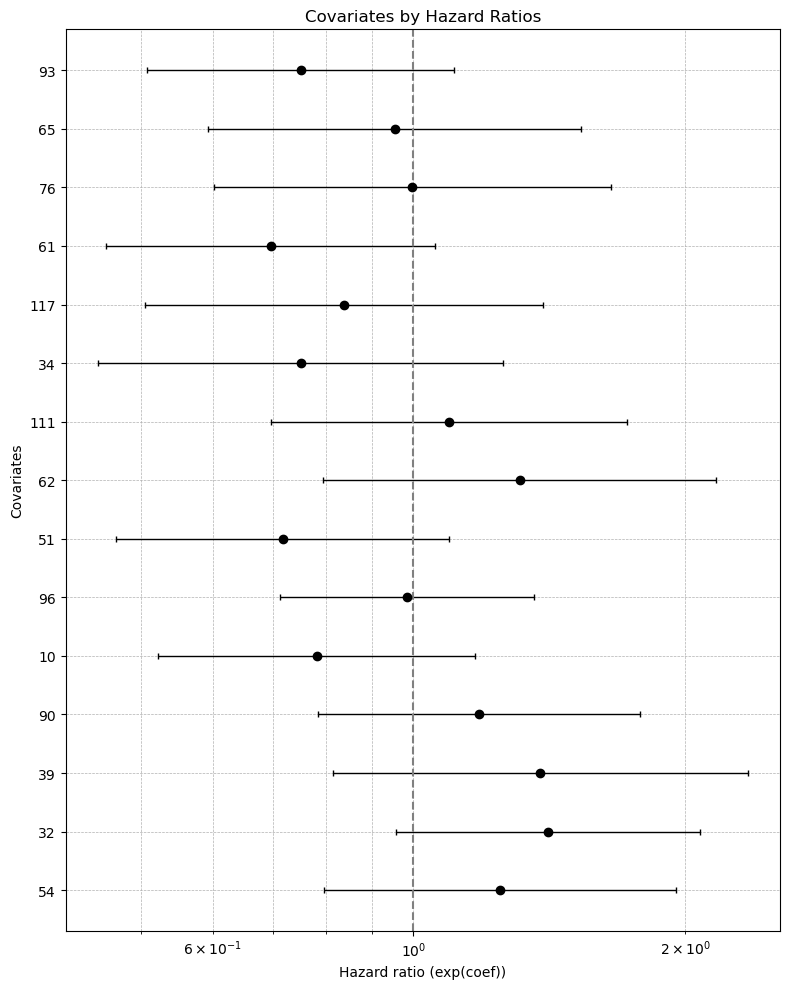

In [136]:
# Plot the forest plot
fig, ax = plt.subplots(figsize=(8, 10))

# Ensure that all covariates are plotted
for index, (covariate, row) in enumerate(best_summary.iterrows()):
    ax.errorbar(row['exp(coef)'], index, 
                 xerr=[[row['exp(coef)'] - row['exp(coef) lower 95%']], 
                      [row['exp(coef) upper 95%'] - row['exp(coef)']]],
                 fmt='o', color='black', ecolor='black', elinewidth=1, capsize=2)

# Highlight the hazard ratio of 1
ax.axvline(x=1, color='grey', linestyle='--')

# Set the scale to log to show a wide range of values
ax.set_xscale('log')

# Set labels and title
plt.xlabel('Hazard ratio (exp(coef))')
plt.ylabel('Covariates')
plt.title('Covariates by Hazard Ratios')
plt.grid(True, which="both", ls="--", linewidth=0.5)

# Adjust y-ticks to show covariate names
ax.set_yticks(range(len(best_summary)))
ax.set_yticklabels(best_summary.index)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

In [137]:
print(best_summary)

               coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  \
covariate                                                                  
54         0.222074   1.248664  0.228961       -0.226680        0.670829   
32         0.343855   1.410374  0.197791       -0.043808        0.731517   
39         0.323589   1.382080  0.269763       -0.205136        0.852315   
90         0.168295   1.183285  0.209342       -0.242007        0.578597   
10        -0.246700   0.781375  0.205578       -0.649626        0.156226   
96        -0.016263   0.983869  0.164938       -0.339535        0.307010   
51        -0.332839   0.716886  0.216700       -0.757563        0.091885   
62         0.271129   1.311444  0.255309       -0.229267        0.771524   
111        0.091603   1.095929  0.231496       -0.362122        0.545327   
34        -0.286645   0.750779  0.263433       -0.802964        0.229675   
117       -0.177306   0.837523  0.259135       -0.685201        0.330589   
61        -0

## Silhouette Score for Various k Values

In [138]:
train_data = pd.read_csv(os.path.join(file_path, f'{model_name}_merged_train_{best_fold}.csv'))
test_data = pd.read_csv(os.path.join(file_path, f'{model_name}_merged_validation_{best_fold}.csv'))
train_data['status'] = train_data['status'].replace({'Alive': 0, 'Dead': 1})
train_data = train_data.dropna()
test_data['status'] = test_data['status'].replace({'Alive': 0, 'Dead': 1})
test_data = test_data.dropna()

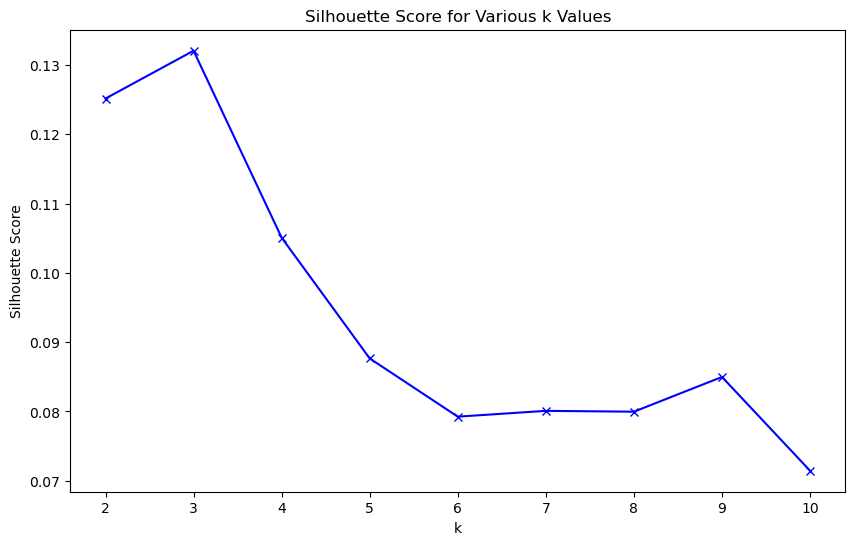

In [139]:
X = train_data[covariates]

silhouette_scores = []
k_values = range(2, 11)  
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Various k Values')
plt.show()

# Kaplan-Meier Survival Curve

Best k by silhouette score: 3


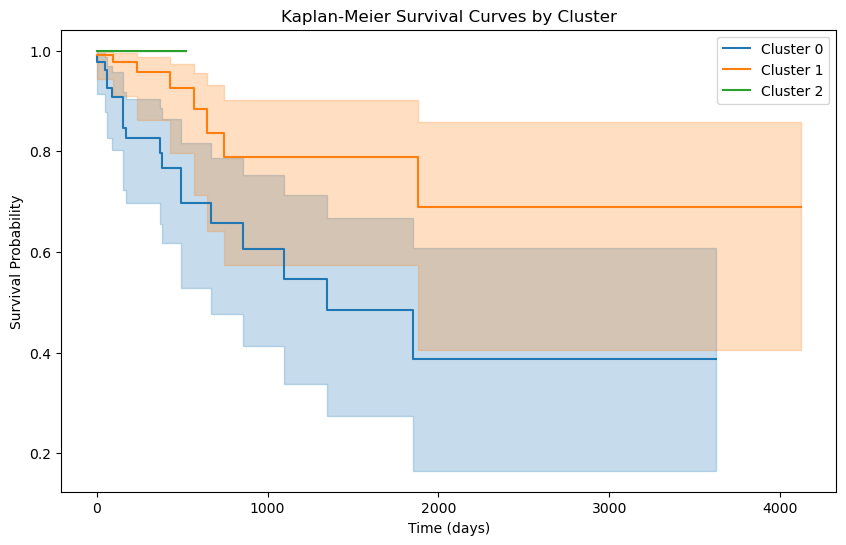

   test_statistic         p  -log2(p)
0        8.792825  0.012321  6.342683


In [140]:
best_k = k_values[np.argmax(silhouette_scores)]
print("Best k by silhouette score:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42)
train_data['cluster'] = kmeans.fit_predict(X)

duration = train_data['months']
event = train_data['status']

kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))
for i in range(best_k):
    kmf.fit(duration[train_data['cluster'] == i], event[train_data['cluster'] == i], label=f'Cluster {i}')
    kmf.plot()

plt.title('Kaplan-Meier Survival Curves by Cluster')
plt.ylabel('Survival Probability')
plt.xlabel('Time (days)')
plt.show()

results = multivariate_logrank_test(duration, train_data['cluster'], event)
print(results.summary)

In [141]:
final_model = CoxPHFitter()
final_model.fit(train_data[covariates + ['months', 'status']], duration_col='months', event_col='status')

train_data['risk_score'] = final_model.predict_partial_hazard(train_data[covariates])
train_data = train_data[train_data['risk_score'] <= 10]

train_data['risk_group'] = 'low'
train_data.loc[train_data['risk_score'] > train_data['risk_score'].median(), 'risk_group'] = 'high'

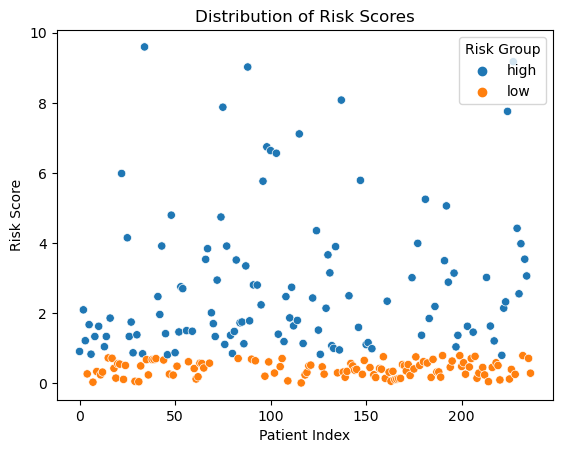

In [142]:
sns.scatterplot(x=train_data.index, y=train_data['risk_score'], hue=train_data['risk_group'])
plt.xlabel('Patient Index')
plt.ylabel('Risk Score')
plt.title('Distribution of Risk Scores')
plt.legend(title='Risk Group', loc = 'upper right')
plt.show()

## ROC Curve

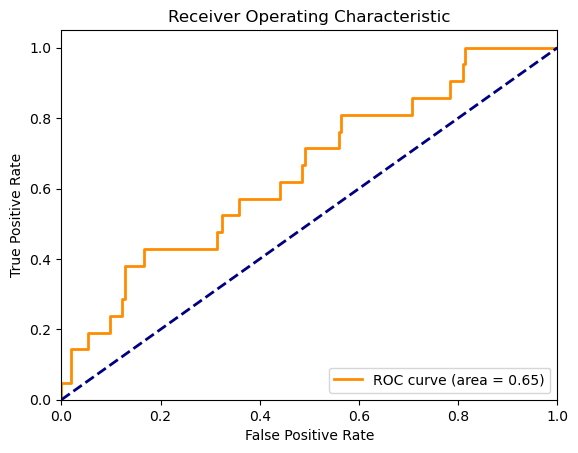

In [143]:
fpr, tpr, thresholds = roc_curve(train_data['status'], train_data['risk_score'])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Feature Expression Correlation Matrix

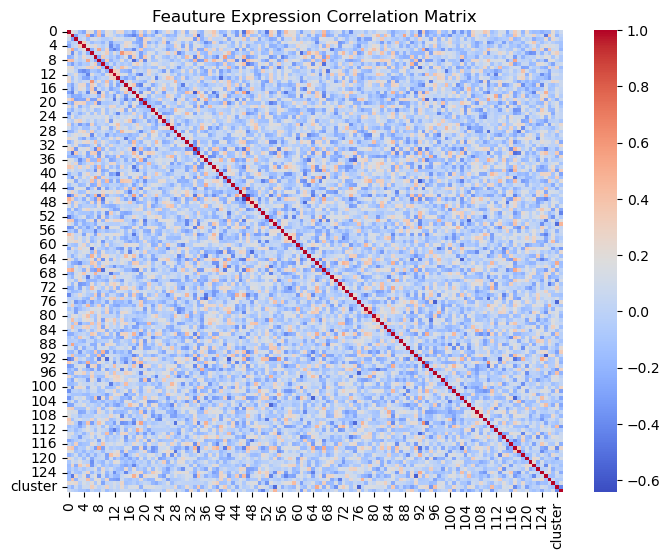

In [144]:
gene_columns = [col for col in train_data.columns if col not in ['Unnamed: 0',  'status', 'months']]
gene_cor_matrix = train_data[gene_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(gene_cor_matrix, annot=False, cmap='coolwarm')
plt.title('Feauture Expression Correlation Matrix')
plt.show()